<a href="https://colab.research.google.com/github/collinjennings/characterspace/blob/main/multi_NovelCharSpace_Git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Novel Character Space Clustering
**4.1.25**

This code is messy. I plan to clean it up soon.

In [ ]:
%matplotlib inline
import string
import pickle
from collections import Counter
import time
import numpy as np
import csv
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from collections import defaultdict
import glob
from sklearn.manifold import TSNE
import pandas as pd
import json
import torch
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
device = torch.device('cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


## For processing new novels

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/booknlp-main')
from booknlp.booknlp import BookNLP

using device cuda


Next steps -- use metadata to filter the list of filenames that I'll grab for producing the clustered space.

In [ ]:
with open("2_txtlab_Novel450.csv") as f:
    a = [{k.strip(): v.strip() for k, v in row.items() if v is not None  } for row in csv.DictReader(f)]

In [ ]:
done_novels = glob.glob("./novel_files/*")
done_novels = [i.split('/')[2] for i in done_novels]


In [ ]:
author_list = ['Woolf,Virginia', 'Joyce,James', 'Wharton,Edith', 'James,Henry', 'Forster,E.M.'] #'Austen,Jane', 'Edgeworth,Maria', 'Shelley,Mary', 'Radcliffe,Ann']
author_list2 = ['Burney,Fanny', 'Austen,Jane', 'Scott,Walter', 'Radcliffe,Ann', 'Gaskell,Elizabeth', 'Eliot,George', 'Dickens,Charles',
                'Trollope,Anthony', 'Lewis,Matthew', 'Collins,Wilkie', 'Edgeworth,Maria', 'Ainsworth,William', 'Cooper,JamesFenimore',
                'Peacock,ThomasLove', 'Martineau,Harriet', 'Hogg,James']

In [ ]:
### Filter
filter_files = []
for i in a:
  if i['author'] in author_list or i['author'] in author_list2 and i['person'] == 'third':
    filter_files.append(i['filename'])
supplements = ['EN_1817_Austen,Jane_NorthangerAbbey_Novel.txt', 'EN_1817_Austen,Jane_Persuasion_Novel.txt', 'EN_1814_Scott,Walter_TheAntiquary_Novel.txt',
               'EN_1814_Burney,Frances_TheWanderer_Novel.txt', 'EN_1815_Austen,Jane_Emma_Novel.txt',
               'EN_1811_Brunton,Mary_SelfControl_Novel.txt', 'EN_1788_Smith,Charlotte_Emmeline_Novel.txt']
filter_files.extend(supplements)

In [ ]:
filter_files[26] = 'EN_1908_Forster,EM_ARoomWithaView_Novel.txt'
filter_files[27] = 'EN_1910_Forster,EM_HowardsEnd_Novel.txt'
filter_files[32] = 'EN_1925_Woolf,Virginia_MrsDalloway_Novel.txt'
filts[38] = 'EN_1814_Burney,Fanny_TheWanderer_Novel'

In [ ]:
filts = [f.split('.')[0] for f in filter_files]
authorDict = dict()
for f in filts:
  authorDict[f.split('_')[3]] = f.split('_')[2]

### Set up files for processing novels with BookNLP

### Create the character contexts

In [ ]:
### For use after generating the book files
file_roots = []
for name in filter_files:

  short_name = name.split('.')[0]
  file_roots.append(short_name)

In [ ]:
file_roots2 = [filt.split('.')[0] for filt in filter_files[15:23]]

In [ ]:
### Stopped at processing the output files
token_lists = []
book_lists = []
entities_lists = []
titles2 = []
for short in file_roots2:
  if short == 'EN_1815_Austen,Jane_Emma_Novel' or 'Pride' in short:
    print(short)
    continue
  else:
    stem = short + '/' + short
    bk_file = stem + '.book'
    if not os.path.exists(bk_file):
      continue
    else:
      titles2.append(short.split('_')[3])
      charData=proc(bk_file)
      book_lists.append(charData)
      token_lists.append(pd.read_csv(stem + '.tokens',  delimiter="\t", encoding='latin1', quoting=csv.QUOTE_NONE, low_memory=False))
      entities_lists.append(pd.read_csv(stem + '.entities', delimiter="\t", quoting=csv.QUOTE_NONE))
print(len(titles2))

7


In [ ]:
print(file_roots2)
print(len(book_lists))

['EN_1838_Martineau,Harriet_Deerbrook_Novel', 'EN_1848_Gaskell,Elizabeth_MaryBarton_Novel', 'EN_1854_Gaskell,Elizabeth_NorthandSouth_Novel', 'EN_1859_Dickens,Charles_ATaleofTwoCities_Novel', 'EN_1860_Collins,Wilkie_TheWomaninWhite_Novel', 'EN_1860_Eliot,George_TheMillontheFloss_Novel', 'EN_1862_Eliot,George_Romola_Novel', 'EN_1869_Trollope,Anthony_PhineasFinn_Novel']
7


In [ ]:

for idx, bk in enumerate(book_lists):
  character_contexts = defaultdict(list)
  c_ids = get_char_ids(bk)
  character_pairs = [pair_ids_names(id, bk) for id in c_ids]
  entities = entities_lists[idx]
  tokens = token_lists[idx]
  for pair in character_pairs:
    label = titles2[idx]+'_' + pair[0]
    character_contexts[label].extend(grab_context_windows(pair[1], entities, tokens))
  with open('./character_contexts/'+titles2[idx]+'_character_contexts.pickle', 'wb') as handle:
    pickle.dump(character_contexts, handle, protocol=pickle.HIGHEST_PROTOCOL)

  print(titles2[idx]+' contexts done!')



Deerbrook contexts done!
MaryBarton contexts done!
NorthandSouth contexts done!
ATaleofTwoCities contexts done!
TheWomaninWhite contexts done!
TheMillontheFloss contexts done!
Romola contexts done!


## Load and visualize character contexts

In [ ]:
def load_char_contexts(filename):
  with open(filename, 'rb') as handle:
    novel_contexts = pickle.load(handle)
  return novel_contexts

In [ ]:
cut_novels = ['Mary', 'Maria', "Alice'sAdventureinWonderland", 'Frankenstein']

In [ ]:
file_roots = [r.split('_')[3] for r in file_roots]

In [ ]:
titles.extend(file_roots)

In [ ]:
files = glob.glob("./character_contexts/*_character_contexts.pickle")

In [ ]:
titles = file_roots

In [ ]:
### Load processed character contexts
import glob
character_contexts = defaultdict(list)
#titles = []
for f in files:
  stem = f.split('_')[1].split('/')[1]
  if stem in titles:
    #titles.append(stem)
    novel_contexts = load_char_contexts(f)
    if 'Pride' in f:
      name = 'PrideandPrejudice_'
      for k in novel_contexts.keys():
        character_contexts[name+k].extend(novel_contexts[k])
    else:
      for k in novel_contexts.keys():
        if k.split('_')[0] in titles:
          character_contexts[k].extend(novel_contexts[k])
print(len(titles))
print(len(character_contexts.keys()))

42
744


In [ ]:
## Remove accidental duplicate contexts -- Need to debug code for producing contexts.
for k in character_contexts.keys():
  character_contexts[k] = list(set(character_contexts[k]))

In [ ]:
## Pop out P&P keys then try to add the contexts again
len(character_contexts.keys())

744

In [ ]:
for i in titles:
  count = 0
  for x in names:
    if i in x:
      count += 1
  if count == 0:
    print(i)

In [ ]:
count = 0
filtered_contexts = defaultdict(list)
for k in character_contexts.keys():
  if len(character_contexts[k]) > 100:
    filtered_contexts[k] = character_contexts[k]
    count+=1
print(count)

334


In [ ]:
len(file_roots)

30

In [ ]:
checkTitles = ['Deerbrook', 'MaryBarton', 'NorthandSouth', 'ATaleofTwoCities', 'TheWomaninWhite','TheMillontheFloss', 'Romola', 'PhineasFinn',]

## Visualizing Character Clusters

In [ ]:
austen = ['PrideandPrejudice', 'Emma', 'SenseandSensibility', 'MansfieldPark']

In [ ]:
names = []
texts = []
for name, context in filtered_contexts.items():
  #for i in austen:
    #if i in name:
  names.append(name)
  texts.append(' '.join(context))
print(len(names))

334


In [ ]:
#filtered_contexts['Emma_Emma']

In [ ]:
texts[0]

"And they are really to be married cried as soon as they were by themselves How strange this is And she ceased speaking replied thus My dear I have the highest opinion in the world in your excellent judgement in myself no nonsense I desire you to stay where you are And upon 's seeming really with vexed and embarrassed to all their impertinence with the most forbearing courtesy feeling it incumbent on her to relieve him from so unpleasant _ upon your staying and hearing would not oppose such an injunction and a moment 's consideration making her also so kind as to listen to took an opportunity of thanking her It keeps him in good humour said she Really cried with some warmth you puzzle me exceedingly If what I have hitherto said can appear to you in be angry On such encouragement to ask was forced to put it out of her power by running away But say that knows him replied the other thought this was going pretty far and she listened with increasing astonishment as begins to say that he wil

In [ ]:
pickle.dump(names, open('all_novels_names.pkl', 'wb'))
pickle.dump(texts, open('all_novels_texts.pkl', 'wb'))
pickle.dump(titles, open('all_novels_titles.pkl', 'wb'))

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stops = list(set(stopwords.words('english')))
stops.append("'s")
stops.append('_')
stops.append('chapter')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
t0 = time.process_time()
vectorizer = TfidfVectorizer(input='content', decode_error='replace', ngram_range=(1,2), stop_words=stops,
                             max_features=2000, min_df=.30, norm='l2', use_idf=True)
dtm = vectorizer.fit_transform(texts)
vocab = vectorizer.get_feature_names_out()
dtm2 = dtm.toarray()
vocab = np.array(vocab)

from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(dtm)

print(len(vocab))
print(time.process_time() - t0)

996
7.874598170999995


In [ ]:
print(vocab[:100])

['able' 'absence' 'absent' 'absolutely' 'accept' 'accepted' 'accompanied'
 'account' 'acquaintance' 'acquainted' 'across' 'act' 'actually' 'added'
 'address' 'addressed' 'addressing' 'admiration' 'advanced' 'advantage'
 'advice' 'affair' 'affairs' 'affected' 'affection' 'afraid' 'afternoon'
 'afterwards' 'age' 'agitation' 'ago' 'agreeable' 'agreed' 'ah' 'air'
 'alarm' 'alarmed' 'allow' 'allowed' 'almost' 'alone' 'along' 'aloud'
 'already' 'also' 'always' 'among' 'anger' 'angry' 'announced' 'another'
 'answer' 'answered' 'anxiety' 'anxious' 'anything' 'apartment' 'appear'
 'appearance' 'appeared' 'approach' 'approached' 'approaching' 'arm'
 'arms' 'around' 'arrival' 'arrived' 'ashamed' 'aside' 'ask' 'asked'
 'asking' 'assistance' 'assure' 'assured' 'astonished' 'astonishment'
 'attachment' 'attempt' 'attend' 'attended' 'attention' 'aunt' 'avoid'
 'aware' 'away' 'back' 'bad' 'bear' 'beautiful' 'beauty' 'became' 'become'
 'bed' 'beg' 'began' 'begged' 'begin' 'beginning']


In [ ]:
pickle.dump(vocab, open('all_novels_vocab.pkl', 'wb'))
pickle.dump(dist, open('all_novels_dist.pkl', 'wb'))

In [ ]:
pickle.dump(dtm2, open('all_novels_dtm.pkl', 'wb'))

In [ ]:
pos = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=28).fit_transform(dist) #25
xs, ys = pos[:, 0], pos[:, 1]

In [ ]:
del names[232]
#del titles[14]
del texts[232]

In [ ]:
clusters = []
for n in names:
  title = n.split('_')[0]
  if title in authorDict.keys():
    clusters.append(authorDict[title])
  else:
    print(title)

In [ ]:
for n in names:
  if 'NorthandSouth' in n:
    print(n)

NorthandSouth_Margaret
NorthandSouth_Mr. Thornton
NorthandSouth_Mr. Hale
NorthandSouth_Mr. Bell
NorthandSouth_Mrs. Thornton
NorthandSouth_Mr. Lennox
NorthandSouth_Higgins
NorthandSouth_Dixon
NorthandSouth_Mrs. Hale
NorthandSouth_Frederick
NorthandSouth_Edith
NorthandSouth_Miss Hale


In [ ]:
print(names[4])
print(clusters[4])

PrideandPrejudice_Mr. Collins
Austen,Jane


In [ ]:
viz_df = pd.DataFrame(dict(x=xs, y=ys,label=names, colors = clusters))

In [ ]:
check = ['PrideandPrejudice_Elizabeth', 'Emma_Emma',  'SenseandSensibility_Marianne', 'TheMysteriesofUdolpho_Emily',
         'TheItalian_Vivaldi', 'MrsDalloway_Clarissa', 'NorthandSouth_Margaret'] #, 'MansfieldPark_Fanny'] #, "TotheLighthouse"]
notList = ['TheMysteriesofUdolpho_Madame Cheron', 'TheWomaninWhite_Madame Fosco', 'PortraitofaLady_Isabel', 'Camilla_Mrs. Berlinton',
           'Romola_Bardo', 'NorthandSouth_Dixon']

In [ ]:
groups = viz_df.groupby('colors')

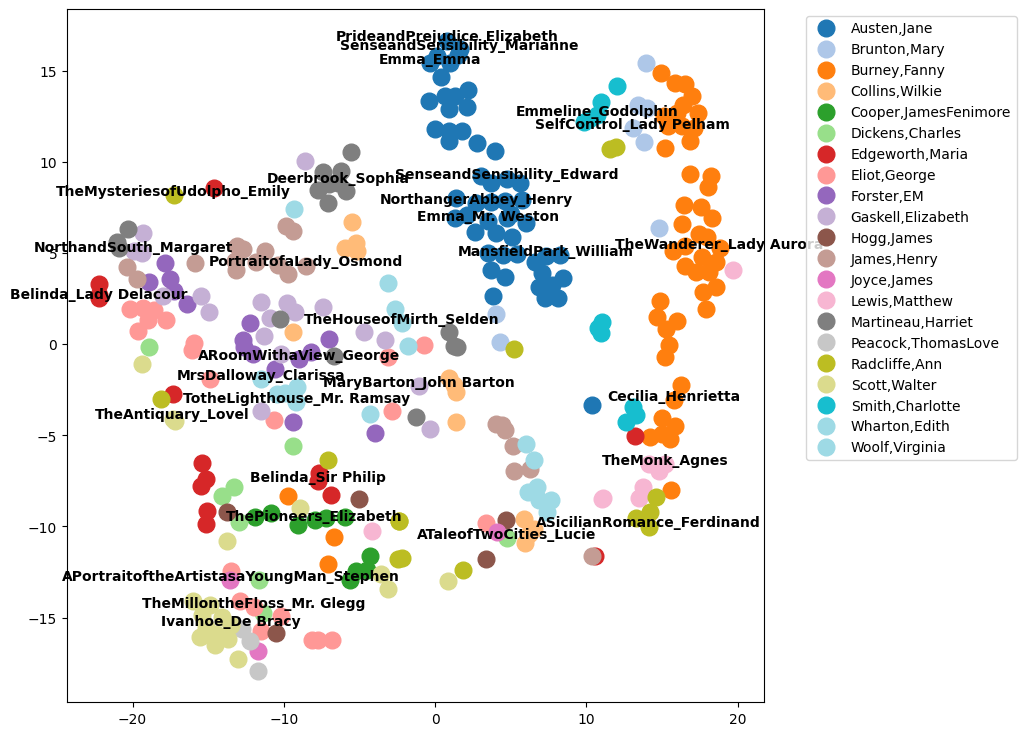

In [ ]:
### Full long 19th-c novel set

fig, ax = plt.subplots(figsize=(9,9))
ax.margins(0.05)

cmap = plt.get_cmap('tab20', len(groups))

for i, (name, group) in enumerate(groups):
  color = cmap(i)
  ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, color=color, label=name) # c=group.colors, cmap=cmap, label=name, norm=norm) #, cmap='tab20') #, color=cluster_colors[name]) #, ## removed cluster_name dict
            #mec='none')
  ax.legend(numpoints=1, bbox_to_anchor=(1.05, 1), loc='upper left')
#for name, group in groups:  ### Look up how i did this!
#plot = ax.scatter(viz_df.x, viz_df.y, marker='o', linestyle='',
            #label=viz_df.label, c=viz_df.colors, cmap='tab20') #, c=df.date, cmap='gray')
#ax.legend(viz_df.colors)

#fig.legend(plot)
#add label in x,y position with the label as the film title
for i in range(len(viz_df)):
    if i % 11 == 0 or viz_df.loc[i]['label'] in check:
      if viz_df.loc[i]['label'] not in notList:
        ax.text(viz_df.loc[i]['x'], viz_df.loc[i]['y'], viz_df.loc[i]['label'], horizontalalignment='center', weight='bold', size=10)
plt.savefig('19thCNovels-characterspaceTSNE-withIDF-NoStopsContentWords.png', dpi=200, bbox_inches='tight')

plt.show()

In [ ]:
xLimit = -12
yLimit = 10
aboveVal = True
ToTheLeftVal = True

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import bookFunctions

In [ ]:
posGroup, notGroup = bookFunctions.singleSeparator(pos, xLimit, xVal=True, above=False)

In [ ]:
## High content words
avgArray, notAvgArray = bookFunctions.analyzer(dtm2, posGroup, notGroup)
austenFull, notAustenFull = bookFunctions.valueRanker(bookFunctions.differencer
                                                             (avgArray, notAvgArray),  vocab, 100)
### Overrepresented in Austen's heroines
print(sorted(austenFull, key=lambda x:x[1], reverse=True))
print()
print(sorted(notAustenFull, key=lambda x:x[1], reverse=True))

[('could', 0.09131076624594531), ('cried', 0.05907456684335162), ('would', 0.05697284954611129), ('though', 0.045552336052866405), ('soon', 0.040096408497884095), ('dear', 0.03665400695539394), ('upon', 0.03360486768755504), ('much', 0.032863975718624205), ('every', 0.03203068626358406), ('indeed', 0.027637378296552877), ('might', 0.026426612379068674), ('however', 0.026187800674455003), ('therefore', 0.026186824997923457), ('without', 0.025752407115271138), ('heart', 0.02510441693849004), ('pleasure', 0.023941048212761124), ('saw', 0.02307763297928274), ('letter', 0.02306116135420832), ('sister', 0.022139380312924672), ('first', 0.02155768124805084), ('must', 0.021145841222260667), ('immediately', 0.020925658116490352), ('felt', 0.020848110906722277), ('yet', 0.020624272311266845), ('well', 0.020071512995589763), ('return', 0.02000765408539402), ('regard', 0.019929653652055672), ('feelings', 0.019551269598699107), ('happy', 0.01923441401403116), ('party', 0.018295068963748908), ('till

In [ ]:
## High content words - Scott Section
avgArray, notAvgArray = bookFunctions.analyzer(dtm2, posGroup, notGroup)
scottFull, notScottFull = bookFunctions.valueRanker(bookFunctions.differencer
                                                             (avgArray, notAvgArray),  vocab, 100)
### Overrepresented in Austen's heroines
print(sorted(scottFull, key=lambda x:x[1], reverse=True))
print()
print(sorted(notScottFull, key=lambda x:x[1], reverse=True))

[('said', 0.07493790345615686), ('old', 0.02348166254566941), ('like', 0.020810604588682745), ('man', 0.020499718576293784), ('come', 0.017561000050029273), ('one', 0.01518179077940747), ('face', 0.015006806204769133), ('things', 0.014122618953526617), ('back', 0.012219210738798), ('stood', 0.01079224858491109), ('show', 0.010620919076796055), ('life', 0.01060186283781564), ('people', 0.01044196599851128), ('night', 0.009807127893654722), ('men', 0.00958709953528055), ('yes', 0.00933656684642923), ('ca', 0.00926089267318265), ('fact', 0.009125953518455947), ('asked', 0.008957009840602409), ('lay', 0.00866597951411108), ('oh', 0.008625821338724096), ('lady', 0.008525769063426277), ('light', 0.008237989031972587), ('got', 0.007759109178771616), ('white', 0.00774352429302032), ('know', 0.0076606384168581565), ('black', 0.0072834371615660524), ('head', 0.007274319330696565), ('along', 0.007268590756633427), ('dead', 0.007045609124586588), ('wo', 0.007037703732738754), ('children', 0.007002

In [ ]:
## High content words - Burney section
avgArray, notAvgArray = bookFunctions.analyzer(dtm2, posGroup, notGroup)
burneyFull, notBurneyFull = bookFunctions.valueRanker(bookFunctions.differencer
                                                             (avgArray, notAvgArray),  vocab, 100)
### Overrepresented in Austen's heroines
print(sorted(burneyFull, key=lambda x:x[1], reverse=True))
print()
print(sorted(notBurneyFull, key=lambda x:x[1], reverse=True))

[('upon', 0.13217367668930285), ('cried', 0.11964124965746697), ('though', 0.053895078210270966), ('yet', 0.04667223210566502), ('answered', 0.03956044987222662), ('therefore', 0.037855903000830395), ('however', 0.03583316533865155), ('without', 0.03356469386283963), ('immediately', 0.03246032929910411), ('whose', 0.031241451907598455), ('till', 0.027444555933818764), ('desired', 0.0267875299477493), ('instantly', 0.02651477718676631), ('every', 0.02587175644113563), ('young', 0.025652321675446232), ('begged', 0.025522380675169577), ('perceived', 0.025416718342420694), ('hastily', 0.023840155690998024), ('length', 0.023771756694462663), ('passion', 0.023589683020067156), ('thus', 0.0235885929738505), ('received', 0.02330064884517429), ('returned', 0.02262608625036048), ('return', 0.021664593560427478), ('still', 0.02079675366890818), ('situation', 0.02037450431349399), ('following', 0.018894293509669396), ('already', 0.018853533742212523), ('means', 0.01874107528396978), ('forced', 0.0

In [ ]:
## High content words - Gaskell/James section
avgArray, notAvgArray = bookFunctions.analyzer(dtm2, posGroup, notGroup)
jamesFull, notJamesFull = bookFunctions.valueRanker(bookFunctions.differencer
                                                             (avgArray, notAvgArray),  vocab, 100)
### Overrepresented in Austen's heroines
print(sorted(jamesFull, key=lambda x:x[1], reverse=True))
print()
print(sorted(notJamesFull, key=lambda x:x[1], reverse=True))

[('said', 0.3100904320128142), ('like', 0.0233838315434551), ('answered', 0.019275416424037996), ('oh', 0.017259405291507192), ('father', 0.016965064926511203), ('shall', 0.015405673551705003), ('looking', 0.015170095228085673), ('love', 0.014044427839138379), ('replied', 0.014011725563129553), ('yes', 0.012622543771595315), ('let', 0.012507016963704709), ('go', 0.012341042307925619), ('asked', 0.012194574149471976), ('head', 0.011664466103833152), ('tell', 0.011478155027084325), ('come', 0.010782352792366973), ('one', 0.010704941577989222), ('man', 0.010470719633110095), ('wo', 0.0104196232315525), ('face', 0.010008054195440309), ('went', 0.00990556390888285), ('yes said', 0.009707013987734258), ('men', 0.009258706448722582), ('things', 0.009228241919408589), ('horse', 0.00916921311022285), ('ca', 0.009040896337744951), ('smiling', 0.008836252154757288), ('right', 0.008787167627943886), ('tone', 0.008660220907913768), ('perhaps', 0.008453098862915696), ('well said', 0.0084131891293737

In [ ]:
### Compare Ares using LIWC Categories

In [ ]:
! pip3 install liwc

In [ ]:
import liwc
parse, category_names = liwc.load_token_parser('e2015.dic')

In [ ]:
jamesHeroCats = []
nonJamesCats = []
for pair in jamesFull:
  for cat in parse(pair[0]):
    jamesHeroCats.append(cat)
for pair in notJamesFull:
  for cat in parse(pair[0]):
    nonJamesCats.append(cat)
print(sorted(Counter(jamesHeroCats).items(), key=lambda x:x[1], reverse=True))
print()
print(sorted(Counter(nonJamesCats).items(), key=lambda x:x[1], reverse=True))

[('verb', 31), ('social', 20), ('cogproc', 14), ('relativ', 14), ('affect', 14), ('function', 13), ('posemo', 13), ('drives', 13), ('percept', 13), ('focuspresent', 12), ('focuspast', 12), ('bio', 9), ('see', 8), ('motion', 8), ('insight', 7), ('adj', 7), ('body', 6), ('male', 5), ('reward', 4), ('power', 4), ('pronoun', 4), ('time', 4), ('tentat', 4), ('prep', 3), ('space', 3), ('affiliation', 3), ('certain', 3), ('focusfuture', 3), ('feel', 3), ('auxverb', 3), ('adverb', 3), ('hear', 3), ('home', 2), ('compare', 2), ('achiev', 2), ('family', 2), ('ipron', 2), ('number', 2), ('ppron', 2), ('informal', 2), ('friend', 1), ('leisure', 1), ('female', 1), ('i', 1), ('negate', 1), ('nonflu', 1), ('discrep', 1), ('differ', 1), ('negemo', 1), ('anx', 1), ('health', 1), ('risk', 1), ('we', 1), ('ingest', 1), ('assent', 1)]

[('relativ', 34), ('cogproc', 28), ('function', 22), ('verb', 22), ('time', 19), ('social', 13), ('focuspast', 13), ('drives', 13), ('adverb', 12), ('motion', 8), ('insight

In [ ]:
heroDict = Counter(jamesHeroCats)
nonDict = Counter(nonJamesCats)
heroRankedList = []
for k in nonDict.keys():
  if k in heroDict.keys():
    heroRankedList.append((k, heroDict[k]/nonDict[k]))
print(sorted(heroRankedList, key=lambda x:x[1], reverse=True))

[('bio', 9.0), ('male', 5.0), ('see', 4.0), ('focuspresent', 4.0), ('percept', 3.25), ('feel', 3.0), ('posemo', 2.1666666666666665), ('power', 2.0), ('reward', 2.0), ('affect', 1.75), ('social', 1.5384615384615385), ('focusfuture', 1.5), ('verb', 1.4090909090909092), ('friend', 1.0), ('tentat', 1.0), ('motion', 1.0), ('drives', 1.0), ('anx', 1.0), ('number', 1.0), ('health', 1.0), ('prep', 1.0), ('focuspast', 0.9230769230769231), ('insight', 0.875), ('adj', 0.875), ('auxverb', 0.75), ('compare', 0.6666666666666666), ('family', 0.6666666666666666), ('home', 0.6666666666666666), ('achiev', 0.6666666666666666), ('certain', 0.6), ('function', 0.5909090909090909), ('cogproc', 0.5), ('risk', 0.5), ('negemo', 0.5), ('affiliation', 0.5), ('leisure', 0.5), ('female', 0.5), ('relativ', 0.4117647058823529), ('space', 0.375), ('discrep', 0.3333333333333333), ('negate', 0.3333333333333333), ('adverb', 0.25), ('time', 0.21052631578947367), ('differ', 0.2)]


In [ ]:
burneyHeroCats = []
nonBurneyCats = []
for pair in burneyFull:
  for cat in parse(pair[0]):
    burneyHeroCats.append(cat)
for pair in notBurneyFull:
  for cat in parse(pair[0]):
    nonBurneyCats.append(cat)
print(sorted(Counter(burneyHeroCats).items(), key=lambda x:x[1], reverse=True))
print()
print(sorted(Counter(nonBurneyCats).items(), key=lambda x:x[1], reverse=True))

[('cogproc', 27), ('relativ', 25), ('affect', 24), ('function', 18), ('drives', 15), ('time', 14), ('verb', 14), ('posemo', 14), ('adverb', 12), ('focuspast', 10), ('negemo', 9), ('insight', 9), ('social', 8), ('motion', 7), ('adj', 7), ('tentat', 6), ('sad', 6), ('achiev', 5), ('space', 5), ('percept', 5), ('focusfuture', 5), ('reward', 4), ('certain', 4), ('power', 4), ('bio', 4), ('focuspresent', 4), ('differ', 4), ('affiliation', 3), ('see', 3), ('discrep', 3), ('compare', 3), ('quant', 3), ('cause', 3), ('conj', 3), ('prep', 3), ('anx', 2), ('risk', 2), ('body', 2), ('negate', 2), ('home', 1), ('work', 1), ('money', 1), ('feel', 1), ('health', 1), ('anger', 1), ('auxverb', 1), ('leisure', 1), ('sexual', 1), ('relig', 1), ('pronoun', 1), ('ipron', 1), ('interrog', 1)]

[('verb', 32), ('cogproc', 25), ('social', 22), ('relativ', 17), ('function', 16), ('focuspresent', 16), ('drives', 14), ('affect', 12), ('percept', 11), ('focuspast', 10), ('posemo', 10), ('adj', 8), ('insight', 8),

In [ ]:
heroDict = Counter(burneyHeroCats)
nonDict = Counter(nonBurneyCats)
heroRankedList = []
for k in nonDict.keys():
  if k in heroDict.keys():
    heroRankedList.append((k, heroDict[k]/nonDict[k]))
print(sorted(heroRankedList, key=lambda x:x[1], reverse=True))

[('negemo', 4.5), ('quant', 3.0), ('focusfuture', 2.5), ('adverb', 2.4), ('affect', 2.0), ('anx', 2.0), ('time', 2.0), ('negate', 2.0), ('differ', 2.0), ('motion', 1.75), ('achiev', 1.6666666666666667), ('prep', 1.5), ('relativ', 1.4705882352941178), ('posemo', 1.4), ('bio', 1.3333333333333333), ('function', 1.125), ('insight', 1.125), ('cogproc', 1.08), ('drives', 1.0714285714285714), ('tentat', 1.0), ('focuspast', 1.0), ('compare', 1.0), ('power', 1.0), ('leisure', 1.0), ('body', 1.0), ('money', 1.0), ('adj', 0.875), ('space', 0.8333333333333334), ('affiliation', 0.75), ('reward', 0.6666666666666666), ('see', 0.6), ('discrep', 0.6), ('certain', 0.5714285714285714), ('feel', 0.5), ('percept', 0.45454545454545453), ('verb', 0.4375), ('social', 0.36363636363636365), ('work', 0.3333333333333333), ('ipron', 0.25), ('focuspresent', 0.25), ('auxverb', 0.25), ('pronoun', 0.2)]


In [ ]:
## Scott and Historical Novel
scottHeroCats = []
nonScottCats = []
for pair in scottFull:
  for cat in parse(pair[0]):
    scottHeroCats.append(cat)
for pair in notScottFull:
  for cat in parse(pair[0]):
    nonScottCats.append(cat)
print(sorted(Counter(scottHeroCats).items(), key=lambda x:x[1], reverse=True))
print()
print(sorted(Counter(nonScottCats).items(), key=lambda x:x[1], reverse=True))

[('verb', 27), ('social', 20), ('relativ', 19), ('focuspast', 14), ('percept', 14), ('drives', 11), ('focuspresent', 11), ('function', 10), ('time', 9), ('cogproc', 9), ('motion', 8), ('bio', 8), ('see', 7), ('body', 6), ('space', 5), ('male', 5), ('feel', 5), ('adj', 5), ('prep', 4), ('pronoun', 4), ('work', 4), ('female', 4), ('insight', 4), ('informal', 3), ('ipron', 3), ('home', 3), ('affect', 3), ('power', 3), ('affiliation', 3), ('family', 3), ('reward', 3), ('hear', 3), ('assent', 2), ('nonflu', 2), ('tentat', 2), ('leisure', 2), ('friend', 2), ('death', 2), ('certain', 2), ('number', 2), ('posemo', 2), ('adverb', 1), ('negemo', 1), ('sad', 1), ('auxverb', 1), ('health', 1), ('compare', 1), ('ppron', 1), ('i', 1), ('risk', 1), ('conj', 1), ('differ', 1), ('discrep', 1), ('ingest', 1), ('achiev', 1)]

[('cogproc', 34), ('function', 23), ('relativ', 22), ('verb', 19), ('social', 17), ('affect', 17), ('time', 17), ('posemo', 13), ('adverb', 13), ('insight', 11), ('drives', 11), ('f

In [ ]:
heroDict = Counter(scottHeroCats)
nonDict = Counter(nonScottCats)
heroRankedList = []
for k in nonDict.keys():
  if k in heroDict.keys():
    heroRankedList.append((k, heroDict[k]/nonDict[k]))
print(sorted(heroRankedList, key=lambda x:x[1], reverse=True))

[('body', 6.0), ('bio', 4.0), ('work', 4.0), ('motion', 4.0), ('female', 4.0), ('pronoun', 4.0), ('see', 3.5), ('power', 3.0), ('reward', 3.0), ('ipron', 3.0), ('feel', 2.5), ('percept', 2.3333333333333335), ('focuspresent', 2.2), ('assent', 2.0), ('nonflu', 2.0), ('male', 1.6666666666666667), ('hear', 1.5), ('informal', 1.5), ('verb', 1.4210526315789473), ('focuspast', 1.4), ('space', 1.25), ('social', 1.1764705882352942), ('friend', 1.0), ('drives', 1.0), ('risk', 1.0), ('leisure', 1.0), ('home', 1.0), ('number', 1.0), ('health', 1.0), ('prep', 1.0), ('relativ', 0.8636363636363636), ('adj', 0.7142857142857143), ('family', 0.6), ('time', 0.5294117647058824), ('affiliation', 0.5), ('achiev', 0.5), ('function', 0.43478260869565216), ('insight', 0.36363636363636365), ('negemo', 0.3333333333333333), ('sad', 0.3333333333333333), ('conj', 0.3333333333333333), ('differ', 0.3333333333333333), ('tentat', 0.2857142857142857), ('cogproc', 0.2647058823529412), ('auxverb', 0.25), ('compare', 0.25)

In [ ]:
heroCats = []
nonCats = []
for pair in austenFull:
  for cat in parse(pair[0]):
    heroCats.append(cat)
for pair in notAustenFull:
  for cat in parse(pair[0]):
    nonCats.append(cat)
print(sorted(Counter(heroCats).items(), key=lambda x:x[1], reverse=True))
print()
print(sorted(Counter(nonCats).items(), key=lambda x:x[1], reverse=True))

[('cogproc', 34), ('function', 23), ('relativ', 22), ('verb', 19), ('social', 17), ('affect', 17), ('time', 17), ('posemo', 13), ('adverb', 13), ('insight', 11), ('drives', 11), ('focuspast', 10), ('certain', 8), ('tentat', 7), ('discrep', 7), ('adj', 7), ('affiliation', 6), ('quant', 6), ('percept', 6), ('family', 5), ('focuspresent', 5), ('auxverb', 4), ('compare', 4), ('focusfuture', 4), ('space', 4), ('prep', 4), ('male', 3), ('negemo', 3), ('sad', 3), ('home', 3), ('conj', 3), ('differ', 3), ('negate', 3), ('friend', 2), ('achiev', 2), ('leisure', 2), ('feel', 2), ('number', 2), ('hear', 2), ('bio', 2), ('informal', 2), ('cause', 2), ('motion', 2), ('see', 2), ('money', 1), ('power', 1), ('risk', 1), ('reward', 1), ('body', 1), ('health', 1), ('assent', 1), ('work', 1), ('female', 1), ('relig', 1), ('pronoun', 1), ('ipron', 1), ('nonflu', 1)]

[('verb', 27), ('social', 20), ('relativ', 19), ('focuspast', 14), ('percept', 14), ('drives', 11), ('focuspresent', 11), ('function', 10),

In [ ]:
heroDict = Counter(heroCats)
nonDict = Counter(nonCats)
heroRankedList = []
for k in nonDict.keys():
  if k in heroDict.keys():
    heroRankedList.append((k, heroDict[k]/nonDict[k]))
print(sorted(heroRankedList, key=lambda x:x[1], reverse=True))

[('adverb', 13.0), ('discrep', 7.0), ('posemo', 6.5), ('affect', 5.666666666666667), ('certain', 4.0), ('auxverb', 4.0), ('compare', 4.0), ('cogproc', 3.7777777777777777), ('tentat', 3.5), ('negemo', 3.0), ('sad', 3.0), ('conj', 3.0), ('differ', 3.0), ('insight', 2.75), ('function', 2.3), ('affiliation', 2.0), ('achiev', 2.0), ('time', 1.8888888888888888), ('family', 1.6666666666666667), ('adj', 1.4), ('relativ', 1.1578947368421053), ('prep', 1.0), ('home', 1.0), ('leisure', 1.0), ('drives', 1.0), ('friend', 1.0), ('number', 1.0), ('health', 1.0), ('risk', 1.0), ('social', 0.85), ('space', 0.8), ('focuspast', 0.7142857142857143), ('verb', 0.7037037037037037), ('informal', 0.6666666666666666), ('hear', 0.6666666666666666), ('male', 0.6), ('assent', 0.5), ('nonflu', 0.5), ('focuspresent', 0.45454545454545453), ('percept', 0.42857142857142855), ('feel', 0.4), ('ipron', 0.3333333333333333), ('power', 0.3333333333333333), ('reward', 0.3333333333333333), ('see', 0.2857142857142857), ('pronou

### Initial visualisation
- Austen's novels are the least like other contemporaries.
- Burney seems to have widest spread, mixing with Radcliffe, Edgeworth
- Radcliffe has the greatest separation among her characters,.

### Next Steps
- Solve the character merging problem (and the missing character - Mr. Collins) for _P&P_.
- Produce the context windows for the 8-12 novels.
- Will I need to keep the gothic novels out? Will their formulaic genre signifiers

In [ ]:
### Iterate through output files and create character context windows for each novel.

In [ ]:
def get_char_ids(character_data):
  char_ids = []
  for char in character_data['characters']:
    if len(char['mentions']['proper']) > 0 and char['mentions']['proper'][0]['c'] > 19:
      char_ids.append(char['id'])
  return char_ids
### Trial version with iterrows()
def grab_context_windows(uid, entities_frame, token_frame):
  context_windows = []
  bad_tags = ['PROPN', 'PUNCT', '"', 'punct']
  for index, row in entities_frame.iterrows():
    if row['COREF'] in uid and row['prop'] == 'PROP':
      new_window = []
      count = 0
      new_index = int(row['start_token'])-10
      for i2, tok_row in token_frame.iloc[new_index:].iterrows():
        if tok_row['POS_tag'] not in bad_tags and count < 20 and tok_row['fine_POS_tag'] not in bad_tags:
          if type(tok_row['word']) == str:
            new_window.append(tok_row['word'])
            count+=1
        elif count == 20:
          break
        else:
          continue
      context_windows.append(' '.join(new_window))
  return context_windows
def pair_ids_names (uid, character_data):
  for char in character_data['characters']:
    if char['id'] == uid:
      return (char['mentions']['proper'][0]['n'], [uid])

## For mistakes in the Character Clustering Algorithm

In [ ]:
def merge_characters(merge_list, char_pairs):
  for item in merge_list:
    for pair in char_pairs:
      if item[0] == pair[0]:
        print(item[0])
        for idx, pair2 in enumerate(char_pairs):
          if item[1] == pair2[0]:
            pair[1].append(pair2[1][0])
            print(pair)
            char_pairs.pop(idx)
          else:
            continue
      else:
        continue
  return char_pairs